# Conditional VAE

Recall that our VAE setup:

The encoder $f_{\phi}(x)$ takes a batch of images, (64, 28, 28), and returns $\mu_z$ and $\log \sigma^2_z$, each of (64, 2), s.t.

$$
q(z \mid x) = \mathbb{N}(\mu_z, \; \text{diag}(\sigma^2_z)) 
$$


The decoder $f_\theta(z)$ takes a batch of $\hat{z} = \mu_z + \sigma_z \cdot \epsilon \sim q(z \mid x)$,
and returns the mean of the reconstructed image $\mu_x$ (64, 28, 28)

where we assumed $\sigma^2_x=0.5$, s.t. 

$$ 
p(x \mid z) = \mathbb{N}(\mu_x, \; \text{diag}(0.5)) 
$$



With cVAE, we simply make the class labels as additional inputs to the encoder and decoder networks. 

s.t. we obtain posterior $q_\phi(z\mid x, y)$ and $p_\theta(x \mid z, y)$ 

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
import tensorflow as tf
import torch
import torch.nn.functional as F

from keras import ops
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Concatenate

## Encoder

The encoder $f_{\phi}(x, y)$ takes a batch of images, (64, 28, 28), and one-hot labels (64, 10) 

returns $\mu_z$ and $\log \sigma^2_z$, each of (64, 2), s.t.

$$
q(z \mid x, y) = \mathbb{N}(\mu_z, \; \text{diag}(\sigma^2_z)) 
$$

In [3]:
image_input = Input(shape=(28, 28), name='image')
label_input = Input(shape=(10,), name='label')

latent_dim = 2

h = Flatten()(image_input)
h = Concatenate(axis=-1)([h, label_input])
h = Dense(512, activation='relu')(h)
h = Dense(32, activation='relu')(h)
h = Dense(2 * latent_dim)(h)
z_mean, z_log_var = ops.split(h, 2, axis=-1)

encoder = Model(inputs=[image_input, label_input], outputs=[z_mean, z_log_var], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 28, 28)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, 10)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 794)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ label[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    407,040 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     16,416 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        132 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split (Split)       │ [(None, 2),       │          0 │ dense_2[0][0]     │
│                     │ (None, 2)]        │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,588 (1.62 MB)

 Trainable params: 423,588 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

## Decoder

The decoder $f_{\theta}(z, y)$ takes a batch of $z$ (64, 2), 
and the corresponding one-hot labels $y$ (64, 10), where $y$ should correspond to the $x$ that generates $z$ in $q(z \mid x)$

returns the mean of the reconstructed image $\mu_x$ (64, 28, 28)

where we assumed $\sigma^2_x=0.5$, s.t. 

$$ 
p(x \mid z, y) = \mathbb{N}(\mu_x, \; \text{diag}(0.5)) 
$$


In [4]:
from keras.layers import Reshape

z_input = Input(shape=(latent_dim,), name='z')

h = Concatenate(axis=-1)([z_input, label_input])
h = Dense(32, activation='relu')(h)
h = Dense(512, activation='relu')(h)
h = Dense(28 * 28)(h)
h = Reshape((28, 28))(h)
x_mean = ops.sigmoid(h)

decoder = Model(inputs=[z_input, label_input], outputs=x_mean, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z (InputLayer)      │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, 10)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12)        │          0 │ z[0][0],          │
│ (Concatenate)       │                   │            │ label[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │        416 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │     16,896 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 784)       │    402,192 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid (Sigmoid)   │ (None, 28, 28)    │          0 │ reshape[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 419,504 (1.60 MB)

 Trainable params: 419,504 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

## Full setup

### Preprocessing

In [5]:
from keras.datasets import mnist
from torch.utils.data import TensorDataset, DataLoader

(x_train, y_train), (x_val, y_val) = mnist.load_data()

def preprocess(image, label):
    return ops.cast(image, 'float32') / 255., ops.one_hot(label, 10)

x_train, y_train = preprocess(x_train, y_train)
x_val, y_val = preprocess(x_val, y_val)

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

### CVAE

In [6]:
from keras.models import Model
from keras.metrics import Mean
import numpy as np


class CVAE(Model):
    
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_metric = Mean(name='loss')
        self.nll_metric = Mean(name='nll')
        self.kl_metric = Mean(name='kl')
        self.pi = ops.array(np.pi)

    def _get_losses(self, data):
        image, label = data
        z_mean, z_log_var = self.encoder([image, label])
        
        batch_size, latent_dim = ops.shape(z_mean)[0], ops.shape(z_mean)[1]
        epsilon = keras.random.normal((5, batch_size, latent_dim))
        z_std = ops.exp(0.5 * z_log_var)
        posterior_samples = z_mean + (z_std * epsilon)  # (5, B, L)

        log_Z = 0.5 * ops.log(2 * self.pi)
        prior_log_prob = -0.5 * ops.square(posterior_samples) - log_Z
        prior_log_prob = ops.mean(ops.sum(prior_log_prob, axis=-1))

        posterior_log_prob = -0.5 * ops.square((posterior_samples - z_mean) / z_std) - ops.log(z_std) - log_Z
        posterior_log_prob = ops.mean(ops.sum(posterior_log_prob, axis=-1))
        
        kl_loss = posterior_log_prob - prior_log_prob
        
        epsilon = keras.random.normal(ops.shape(z_mean))
        z_sample = posterior_samples[0]
        
        x_mean = self.decoder([z_sample, label])
        nll_loss = 0.5 * ops.square((image - x_mean) / 0.5) + ops.log(0.5) + log_Z
        nll_loss = ops.mean(ops.sum(nll_loss, axis=[-1, -2]))

        loss = kl_loss + nll_loss
        return loss, kl_loss, nll_loss
    
    def call(self, inputs):
        if isinstance(inputs, tuple):
            image, label = inputs
        else:
            print(inputs.shape)
            raise ValueError(f"Expected (image, label) tuple, got {type(inputs)}")


        z_mean, z_log_var = self.encoder(inputs)
        epsilon = keras.random.normal(ops.shape(z_mean))
        z_std = ops.exp(0.5 * z_log_var)
        z_sample = z_mean + (z_std * epsilon)
        return self.decoder([z_sample, label])

    def train_step(self, data):
        backend = keras.config.backend()
        if backend == 'tensorflow':
            with tf.GradientTape() as tape:
                loss, kl_loss, nll_loss = self._get_losses(data)
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        elif backend == 'torch':
            self.zero_grad()
            loss, kl_loss, nll_loss = self._get_losses(data)

            loss.backward()

            gradients = [v.value.grad for v in self.trainable_weights]    
            with torch.no_grad():
                self.optimizer.apply(gradients, self.trainable_weights)
        else:
            raise NotImplementedError(f"Unsupported backend: {backend}")
            
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        loss, kl_loss, nll_loss = self._get_losses(data)
        self.loss_metric.update_state(loss)
        self.nll_metric.update_state(nll_loss)
        self.kl_metric.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    @property
    def metrics(self):
        return [self.loss_metric, self.nll_metric, self.kl_metric]

### Training

In [7]:
cvae = CVAE(encoder, decoder, name='cvae')
cvae.compile(optimizer='adam')

# Manually call the model with a batch of data to build it
for batch in train_loader:
    cvae((batch[0], batch[1]))  # explicitly pass (image, label)
    break

cvae.fit(train_loader, validation_data=val_loader, epochs=10)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - kl: 4.9593 - loss: 277.4842 - nll: 272.5248 - val_kl: 3.5252 - val_loss: 243.7113 - val_nll: 240.1861
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - kl: 3.4908 - loss: 242.5442 - nll: 239.0534 - val_kl: 3.6831 - val_loss: 239.3537 - val_nll: 235.6707
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - kl: 3.7619 - loss: 238.8095 - nll: 235.0477 - val_kl: 3.7457 - val_loss: 237.2413 - val_nll: 233.4957
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - kl: 3.8970 - loss: 236.9694 - nll: 233.0724 - val_kl: 3.8853 - val_loss: 235.9740 - val_nll: 232.0887
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - kl: 4.0104 - loss: 235.7918 - nll: 231.7813 - val_kl: 3.9562 - val_loss: 235.2438 - val_nll: 231.2875
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - kl: 4.0717 - loss: 235.2486 - nll: 231.1769 - val_kl: 4.1178 - val_loss: 234.9267 - val_nll: 230.8090
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/ste

### Visualization

Generate $ \hat{z} $ from the prior $ \mathbb{N}(0, I) $, choose a digit $c$ from 0-9, and simply input both to the decoder:

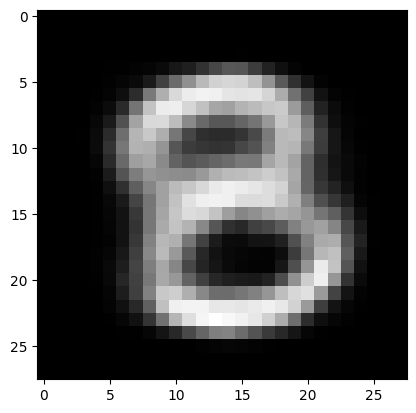

In [9]:
digit = 8
label = ops.one_hot([digit], 10)

sample = decoder([keras.random.normal((1, latent_dim)), label])[0]
sample = sample.detach().cpu().numpy()
plt.imshow(sample, cmap='gray')

### What if the z does not correspond to the y

What if you give a *random* $ z $ and a label $ y $ to the decoder?

#### If $ z \sim p(z) = \mathcal{N}(0, I) $ (prior sampling):

The decoder will try to produce an $ x $ that "looks like" class $ y $, **as long as** the decoder was trained well and the sampled $ z $ is within the region it saw during training.

#### If $ z $ is *unrealistic*, or corresponds to another class $ y' $:
- The decoder **will still try** to generate something that matches $ y $, but:
  - The output might look *off* or noisy.
  - You're feeding it a latent that may not lie on the **manifold** of that class.
  - The decoder might "struggle" and output an ambiguous or nonsensical image.


The decoder is trained to **map combinations of $ z $ and $ y $** to valid images.

But it **only saw certain combinations** during training: $ z \sim q(z|x, y) $, for real $ x $'s in class $ y $.

Say the encoder learns that  $z_1$ is the posterior mean to $x_1, y_1$ in $q(z | x, y)$

If we feed $z_1, y_2$ to the CVAE, or try to make an image of class $ y_2 $ using the latent from class $ y_1 $, it may or may not work well.

The model may be able to interpolate $ z $ between two real latent vectors of class $ y $, and still get reasonable outputs

Here we try looping over a **fixed $ z $** and change $ y $ across all classes:  
"draw what this latent looks like **as if it were** each class"  


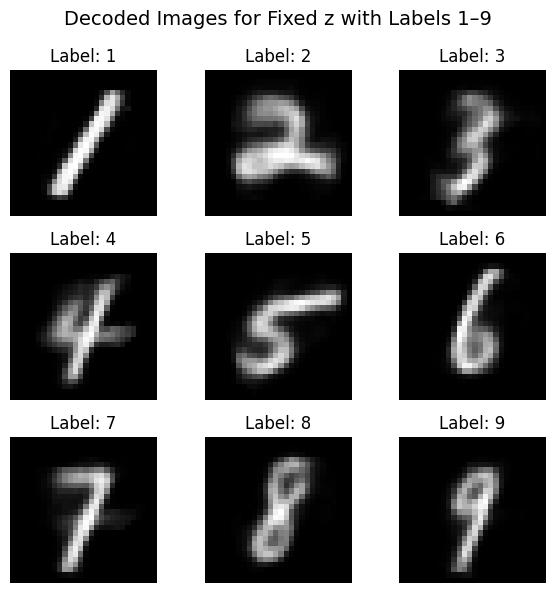

In [11]:
z_rand = keras.random.normal((1, latent_dim))

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle("Decoded Images for Fixed z with Labels 1–9", fontsize=14)

for i, digit in enumerate(range(1, 10)):
    label = ops.one_hot([digit], 10)
    decoded = decoder([z_rand, label])[0]
    image = decoded.detach().cpu().numpy()

    ax = axs[i // 3, i % 3]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {digit}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()
